In [80]:
!pip install -q datasets transformers[torch]

## Importando Bibliotecas

In [99]:
import datasets
import transformers
from datasets import load_dataset
from transformers import ViTImageProcessor
from torchvision.transforms import (CenterCrop, Compose, Normalize,
                                    RandomHorizontalFlip, RandomResizedCrop,
                                    Resize, ToTensor)
from torch.utils.data import DataLoader
import torch
from transformers import ViTForImageClassification, ViTConfig
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [82]:
print('Transformes:',transformers.__version__)
print('Datasets:',datasets.__version__)

Transformes: 4.41.0
Datasets: 2.19.1


## Carregando o Conjunto de Dados

In [83]:
splits = load_dataset('data')['train'].train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']

In [84]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'], id=None)}

In [85]:
val_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'], id=None)}

## Pre-procesando os Dados

In [86]:
#Modelo escolhido.
nome_modelo = 'facebook/dino-vitb16'

processor = ViTImageProcessor.from_pretrained(nome_modelo)

In [87]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

In [88]:
print(train_ds[1])

{'image': <PIL.Image.Image image mode=RGB size=550x362 at 0x1DD69D20D90>, 'label': 2, 'pixel_values': tensor([[[-0.5767, -0.5938, -0.6109,  ..., -1.1760, -1.1760, -1.1760],
         [-0.5767, -0.5938, -0.6109,  ..., -1.1760, -1.1760, -1.1589],
         [-0.5938, -0.6109, -0.6281,  ..., -1.1760, -1.1589, -1.1418],
         ...,
         [-1.0562, -1.0562, -1.0562,  ..., -0.5938, -0.4226, -0.3198],
         [-1.0562, -1.0562, -1.0733,  ..., -0.6623, -0.5424, -0.4568],
         [-1.0562, -1.0562, -1.0733,  ..., -0.7137, -0.6281, -0.5596]],

        [[ 0.0301,  0.0301,  0.0301,  ..., -0.5651, -0.5476, -0.5476],
         [ 0.0476,  0.0476,  0.0476,  ..., -0.5651, -0.5476, -0.5476],
         [ 0.0651,  0.0651,  0.0651,  ..., -0.5476, -0.5301, -0.5301],
         ...,
         [-0.5301, -0.5476, -0.5651,  ..., -0.1450, -0.1099, -0.1099],
         [-0.5301, -0.5476, -0.5651,  ..., -0.2150, -0.2150, -0.2150],
         [-0.5301, -0.5301, -0.5476,  ..., -0.2675, -0.2850, -0.2850]],

        [[-1.7

## Criando o DataLoader

In [89]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [90]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## Definindo o Modelo

In [91]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}

In [92]:
# Carregando a configuração do modelo
config = ViTConfig.from_pretrained(nome_modelo)

# Modificando a configuração para ter o número correto de classes de saída
config.num_labels = len(id2label)

# Carregando o modelo com a configuração modificada
model = ViTForImageClassification.from_pretrained(nome_modelo, config=config, ignore_mismatched_sizes=True)

d:\Users\thale\miniconda3\envs\py310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Definindo os Argumentos de Treinamento

In [93]:
metric_name = "accuracy"

# ajuste os parâmetros do ajuste fino
args = TrainingArguments(
    f"test-data",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir="logs",
    remove_unused_columns=False,
)

d:\Users\thale\miniconda3\envs\py310\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Métricas Personalizadas

In [94]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

## Iniciando o Treinamento

In [95]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

## Treinando o Modelo

In [97]:
trainer.train()


 33%|███▎      | 335/1005 [01:33<02:53,  3.86it/s]

{'eval_loss': 0.15387651324272156, 'eval_accuracy': 0.9534606205250596, 'eval_runtime': 9.3544, 'eval_samples_per_second': 89.584, 'eval_steps_per_second': 22.449, 'epoch': 1.0}


 50%|████▉     | 500/1005 [02:16<02:02,  4.13it/s]

{'loss': 0.1934, 'grad_norm': 28.94402503967285, 'learning_rate': 1.0049751243781096e-05, 'epoch': 1.49}


 67%|██████▋   | 670/1005 [03:08<01:18,  4.25it/s]

{'eval_loss': 0.1378484070301056, 'eval_accuracy': 0.9534606205250596, 'eval_runtime': 9.3505, 'eval_samples_per_second': 89.621, 'eval_steps_per_second': 22.459, 'epoch': 2.0}


100%|█████████▉| 1000/1005 [04:33<00:01,  4.26it/s]

{'loss': 0.1015, 'grad_norm': 0.008659839630126953, 'learning_rate': 9.950248756218906e-08, 'epoch': 2.99}


100%|██████████| 1005/1005 [04:43<00:00,  4.34it/s]

{'eval_loss': 0.10073097050189972, 'eval_accuracy': 0.9737470167064439, 'eval_runtime': 8.9084, 'eval_samples_per_second': 94.069, 'eval_steps_per_second': 23.573, 'epoch': 3.0}


100%|██████████| 1005/1005 [04:48<00:00,  4.34it/s]

{'train_runtime': 287.1828, 'train_samples_per_second': 34.995, 'train_steps_per_second': 3.5, 'train_loss': 0.14706533821068, 'epoch': 3.0}


100%|██████████| 1005/1005 [04:49<00:00,  3.47it/s]


TrainOutput(global_step=1005, training_loss=0.14706533821068, metrics={'train_runtime': 287.1828, 'train_samples_per_second': 34.995, 'train_steps_per_second': 3.5, 'total_flos': 7.865577936728064e+17, 'train_loss': 0.14706533821068, 'epoch': 3.0})

## Avaliando o Ajuste Fino

In [98]:
outputs = trainer.predict(val_ds)

100%|██████████| 210/210 [00:09<00:00, 22.67it/s]


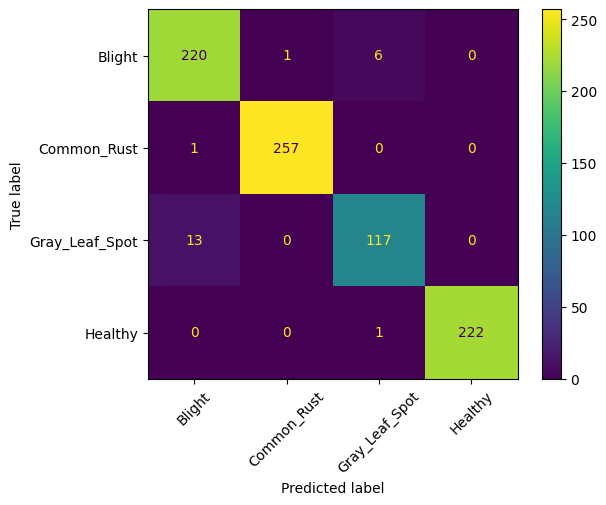

In [100]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)